# Introdução
.

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch

In [2]:
df = pd.read_csv('datasets/music_project_en.csv')

In [3]:
df.head()

,userID,Track,artist,genre,City,time,Day
0,FFB692EC,Kamigata To Boots,The Mass Missile,rock,Shelbyville,20:28:33,Wednesday
1,55204538,Delayed Because of Accident,Andreas Rönnberg,rock,Springfield,14:07:09,Friday
2,20EC38,Funiculì funiculà,Mario Lanza,pop,Shelbyville,20:58:07,Wednesday
3,A3DD03C9,Dragons in the Sunset,Fire + Ice,folk,Shelbyville,08:37:09,Monday
4,E2DC1FAE,Soul People,Space Echo,dance,Springfield,08:34:34,Monday


In [4]:
df.shape

(65079, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65079 entries, 0 to 65078
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0     userID  65079 non-null  object
 1   Track     63736 non-null  object
 2   artist    57512 non-null  object
 3   genre     63881 non-null  object
 4     City    65079 non-null  object
 5   time      65079 non-null  object
 6   Day       65079 non-null  object
dtypes: object(7)
memory usage: 3.5+ MB


In [6]:
df.columns

Index(['  userID', 'Track', 'artist', 'genre', '  City  ', 'time', 'Day'], dtype='object')

In [7]:
df.duplicated().sum()

3826

In [8]:
(df.isna().sum() / df.shape[0] * 100).sort_values(ascending=False)

artist      11.627407
Track        2.063646
genre        1.840840
  userID     0.000000
  City       0.000000
time         0.000000
Day          0.000000
dtype: float64

  
---
Constatações:
* 65079 registros e 7 features
* 3950 registros duplicados
* presença de Missing values
* problema com nomes das features (espaços)
* tipo inválido (time)

# Preprocessing
A seguir os dados serão tratados e os problemas encotrados serão corrigidos, e uma feature adicional será criada para enriquecer a análise.

In [9]:
# Renaming columns
df.columns = df.columns.str.replace(' ', '').str.lower()

In [10]:
# Data-type changing
df.time = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time

In [11]:
# Feature creation
df['hour'] = df.time.apply(lambda x: x.hour)

In [13]:
# Duplicated data removal
df.drop_duplicates(inplace=True)

In [14]:
# Missing values
df.fillna('unknown', inplace=True)

In [16]:
df.duplicated().sum()

0

In [17]:
df.isna().sum()

userid    0
track     0
artist    0
genre     0
city      0
time      0
day       0
hour      0
dtype: int64

# Exploratory data analysis

Para compreender melhor os dados e descobrir relações entre eles será realizada esta análise, tendo como ponto de partida as seguintes hipóteses:

* o dia da semana tem influência na quantidade de músicas escutadas em cada cidade
* existem horários de pico
* nos horários de pico certos gêneros são dominantes
* cada cidade tem uma maior preferência por certos gêneros musicais

In [27]:
pivot = df.pivot_table(values='track', columns='day', index='city', aggfunc='count')
pivot = pivot[['Monday','Wednesday','Friday']]
pivot

day,Monday,Wednesday,Friday
city,,,
Shelbyville,5614,7003,5895
Springfield,15740,11056,15945


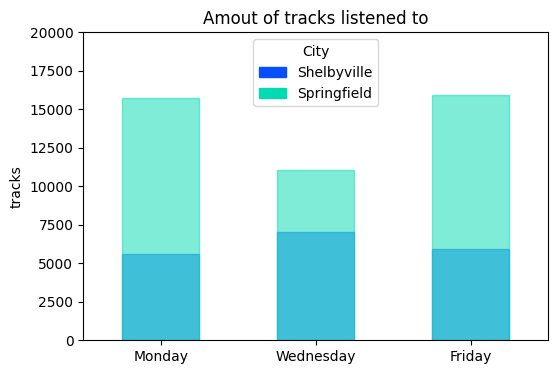

In [166]:
# plot settings
colors = ['#074EFF', '#00DBB3']
total_bars = len(pivot.columns)
indices = pivot.index.values
bar_width = 0.5

# plotting elements
fig, ax = plt.subplots()

for i, (lbl, bar_value) in enumerate(pivot.to_dict().items()):   
    # stacks
    for j, (k,v) in enumerate(bar_value.items()):
        stack = Rectangle((i + (bar_width * .5), 0), bar_width, v, color=colors[j], alpha=0.5)
        ax.add_patch(stack)

# limits
ax.set_xlim(0, 3)
ax.set_ylim(0, 20000)
fig.set_size_inches(6, 4)

# labels and ticks
ax.set_xticks([i + bar_width for i in range(total_bars)])
ax.set_xticklabels((pivot.columns.values))
plt.ylabel('tracks')
plt.title('Amout of tracks listened to')

# legend
ax.legend(handles=[mpatches.Patch(color=colors[i], label=lblname) for i, lblname in enumerate(indices)],
          title = 'City')

plt.show()

Obs.:  
Springfield tem uma quantidade maior de músicas escutadas do que Shelbyville por ser uma cidade maior que Shelbyville.
* Em Shelbyville Quarta feira é o dia com mais músicas escutadas.
* Em Springfield é o contrário, Quarta é o dia com menor quantidade.
* Segunda e Sexta possuem quantidades parecidas em ambas cidades.